# Import Necessary Package

In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt  
import pandas as pd

# Load SUP Data

In [7]:
#SUP = ['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '820', '821', 
#       '822', '823', '824', '825', '826', '827', '828', '829', '840', '841', '842', '843', '844', '845', '846', 
#       '847', '848', '849', '850']
SUP = ['851','852','853','854','855','856','857','858','859','860','861','862','863','864','865','866','867',
       '868','869','870','871','872','873','874','875','876','877','878','879','880','881','882','883','884',
       '885','886','887','888','889','890','891','892','893','894']

SUPSet = {}

for ds in SUP:
    dataSetLoc = 'D:/Data/Data/SUP/' + ds
    record = wfdb.rdsamp(dataSetLoc)
    lead0 = record.p_signals[:,0]
    lead1 = record.p_signals[:,1]
    annotation = wfdb.rdann(dataSetLoc, 'atr')
    annIdx = annotation.sample
    annType = annotation.symbol
    SUPSet[ds] = {'lead0': lead0, 'lead1': lead1, 'annIdx': annIdx, 'annType': annType}
    


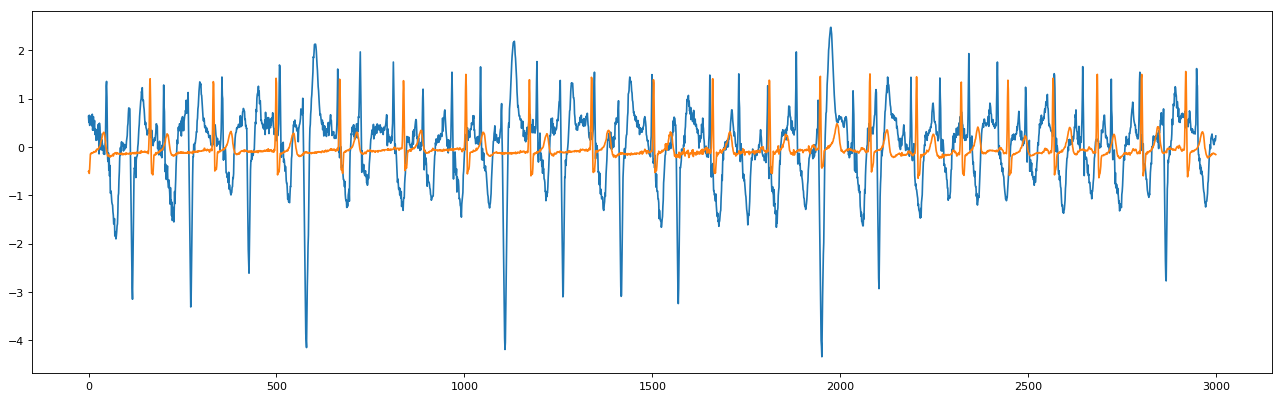

In [9]:
# 测试数据集的读取情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(SUPSet['801']['lead0'][:3000])
plt.plot(SUPSet['800']['lead0'][:3000])
plt.show()

In [1]:
N = ['N', 'L', 'R', 'e', 'j']
SVEB = ['A', 'a', 'J', 'S']
VEB = ['V', 'E']
F = ['F']
Q = ['P', 'f', 'U']
Non_beat_anns = ['[', ']', '!', 'x', '(', ')', 'p', 't', 'u', '`', '~', '^', '|', '+', 's', 'T', '*', 'D', '=', '"', '@']

In [8]:
for ds in SUP:
    for i in SUPSet[ds]['annType']:
        if i in N:
            n+=1
        if i in SVEB:
            s+=1
        if i in VEB:
            v+=1
        if i in F:
            f+=1
        if i in Q:
            q+=1

In [13]:
q

0

# Up Sampling

In [3]:
len(SUPSet['851']['annIdx'])

2769

In [ ]:
ds = '800'
index = pd.date_range('1/1/2000', periods = len(SUPSet[ds]['lead0']), freq='0.0078125S')
tempLead = pd.Series(SUPSet[ds]['lead0'], index=index)
resampled_tempLead = tempLead.resample('0.0028S').pad()

In [ ]:
dt = pd.to_datetime("2000-01-01 00:00:00.007812500")
tempLead.index.get_loc(dt, method='nearest')

In [ ]:

resampled_tempLead.index.get_loc(index[2], method='nearest')

In [4]:
for ds in SUP:
    newAnnIdx = []
    
    index = pd.date_range('1/1/2000', periods = len(SUPSet[ds]['lead0']), freq='0.0078125S')
    tempLead = pd.Series(SUPSet[ds]['lead0'], index=index)
    resampled_tempLead = tempLead.resample('0.0028S').pad()
    SUPSet[ds]['lead0'] = np.array(list(resampled_tempLead))
    
    for i in SUPSet[ds]['annIdx']:
        if i == len(tempLead):
            newAnnIdx.append(len(resampled_tempLead))
            continue
        newAnnIdx.append(resampled_tempLead.index.get_loc(index[i], method='nearest'))
    SUPSet[ds]['annIdx'] = np.array(newAnnIdx)
    
    index = pd.date_range('1/1/2000', periods = len(SUPSet[ds]['lead1']), freq='0.0078125S')
    tempLead = pd.Series(SUPSet[ds]['lead1'], index=index)
    resampled_tempLead = tempLead.resample('0.0028S').pad()
    SUPSet[ds]['lead1'] = np.array(list(resampled_tempLead))

In [ ]:
len(tempLead)

In [5]:
len(SUPSet['851']['annIdx'])

2769

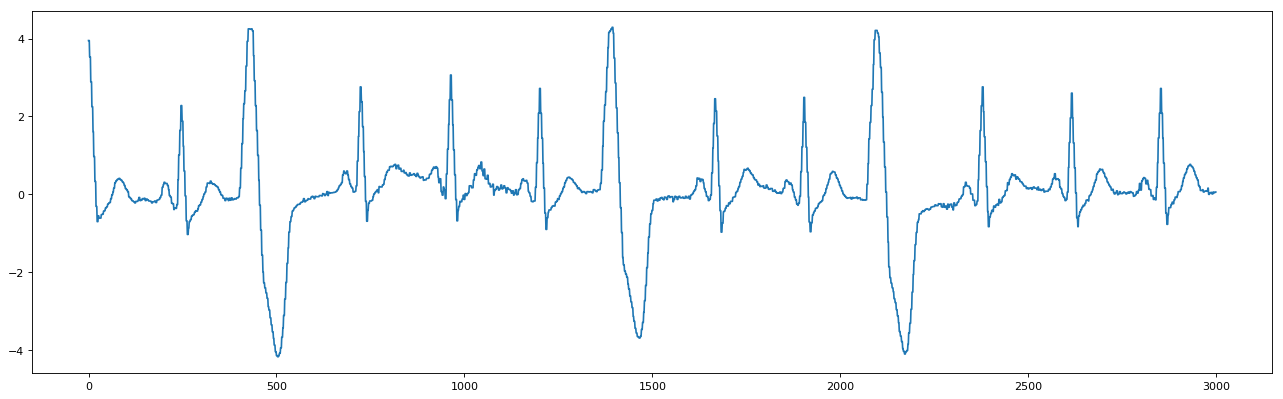

In [6]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(SUPSet['851']['lead0'][:3000])
plt.show()

# Data Denoising

## Baseline Wander Removal

In [7]:
for k, v in SUPSet.items():
    print(k)
    first_filtered = medfilt(v['lead0'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead0'] = v['lead0'] - second_filtered

    first_filtered = medfilt(v['lead1'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead1'] = v['lead1'] - second_filtered

851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894


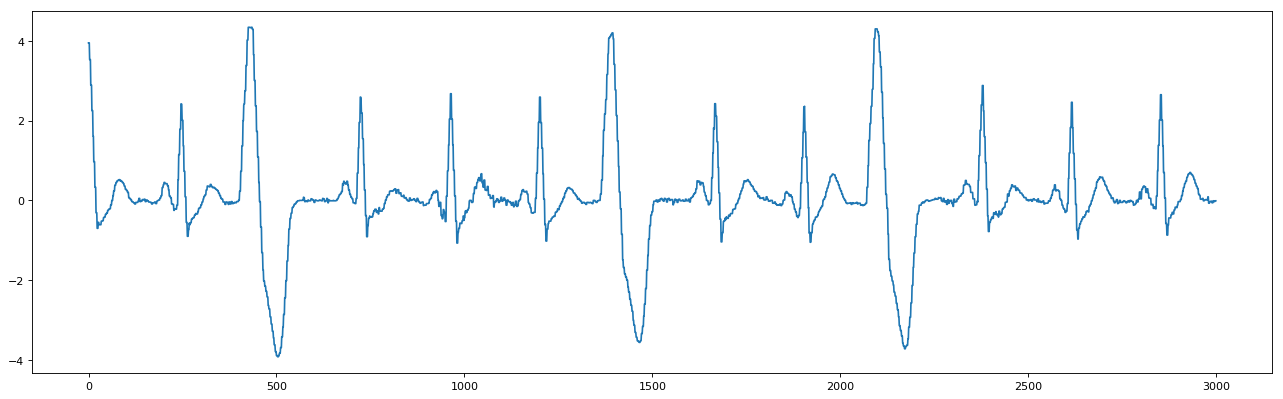

In [8]:
# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(SUPSet['851']['lead0'][:3000])
plt.show()

## High Frequency Noise Removal in Use of Wavelets Transformation

In [9]:
def wt(index_list,wavefunc,lv,m,n):   # 打包为函数，方便调节参数。  lv为分解层数；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
   
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  # 计算阈值
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零

    # 重构
    denoised_index = pywt.waverec(coeff,wavefunc)
    return denoised_index

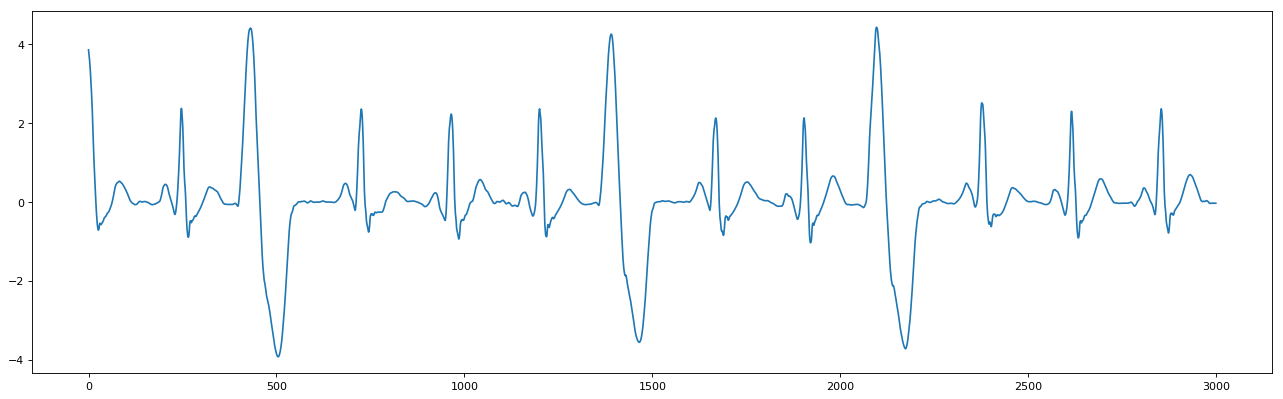

In [10]:
for k, v in SUPSet.items():
    v['lead0'] = wt(v['lead0'],'db4',4,2,4)
    v['lead1'] = wt(v['lead1'],'db4',4,2,4)

# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(SUPSet['851']['lead0'][:3000])
plt.show()

# Save Cleaned Data to CSV

In [11]:
headers = ['lead0', 'lead1', 'annIdx', 'annType']

for k, v in SUPSet.items():
    df1 = pd.DataFrame({ 'lead0': SUPSet[k]['lead0'], 'lead1': SUPSet[k]['lead1']})
    df1.to_csv('Cleaned SUP/' + k + '_lead.csv', index=False)
    
    df2 = pd.DataFrame({ 'annIdx': SUPSet[k]['annIdx'], 'annType': SUPSet[k]['annType']})
    df2.to_csv('Cleaned SUP/' + k + '_ann.csv', index=False)

In [12]:
# 测试存储情况
df_lead = pd.read_csv('Cleaned SUP/851_lead.csv')
df_ann = pd.read_csv('Cleaned SUP/851_ann.csv')
df_lead
df_ann

,annIdx,annType
0,237,N
1,424,V
2,536,|
3,717,N
4,954,N
5,1194,N
6,1384,V
7,1496,|
8,1660,N
9,1897,N


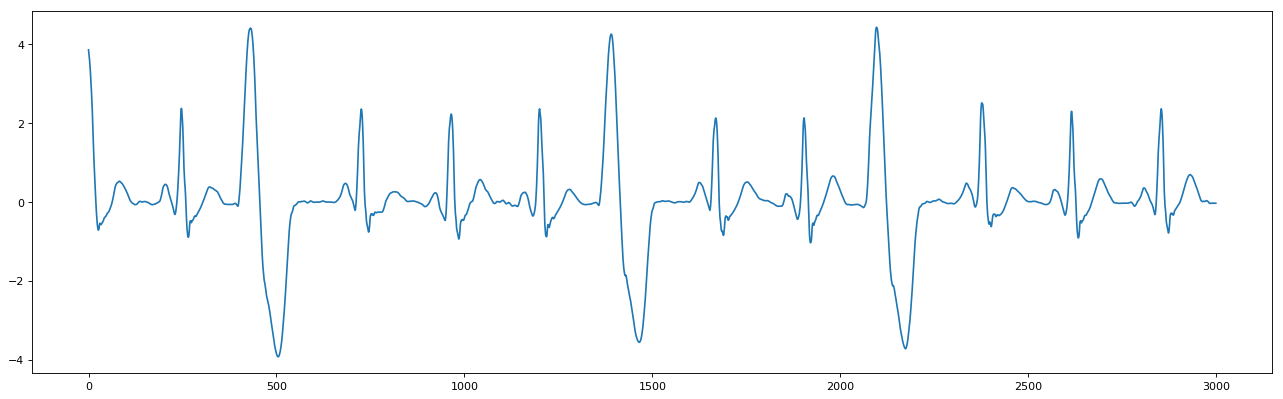

In [13]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(df_lead['lead0'][:3000])
plt.show()